
# Galves-Löcherbach Model

"GL model assumes that the firing of the neuron is a random event, whose probability of occurrence in any time step is a firing function Φ(V) of membrane potential V. By subsuming all sources of randomness into a single function, the Galves-Löcherbach (GL) neuron model simplifies the analysis and simulation of noisy spiking neural networks." [DOI: 10.1038/srep35831]

Reproduce the results of: Antonio Galves, Eva Löcherbach, Christophe Pouzat, Errico Presutti, "A system of interacting neurons with short term synaptic facilitation". arXiv:1903.01270v3 13 Sep 2019

Tsodyks-Markram model formally equivalent for synapse (when set to no depression, only facilitation)

Morrison A., Diesmann M., Gerstner W. (2008) Phenomenological models of synaptic plasticity based on spike timing. Biological Cybernetics 98:459–478.
DOI: 10.1007/s00422-008-0233-1.


Preliminaries
-------------

In [1]:
%matplotlib inline
from typing import Dict, Optional

import matplotlib as mpl

mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

import matplotlib.pyplot as plt

import nest
import numpy as np
import os
import random

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

import logging
logging.getLogger('matplotlib.font_manager').disabled = True


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Feb 22 2024 10:55:27

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



GL model with physical units
----------------------------


In [2]:
# Neuron parameters
params = {
    'tau_m'   : 10.0,
    't_ref'   : 2.0,
    'C_m'     : 250.0,
    'V_r'     : -65.0,
    'V_reset' : -65.0,
    'a'       : 1.2,
    'b'       : 27.0,
    'V_b'     : -51.3
}

In [15]:
nestml_gl_exp_model = """
neuron gl_exp:
    state:
        refr_spikes_buffer mV = 0 mV
        refr_tick integer = 0    # Counts number of tick during the refractory period
        V_m mV = V_r     # Membrane potential

    equations:
        kernel G = delta(t)
        V_m' = -(V_m - V_r) / tau_m + (mV / ms) * convolve(G, spikes) + (I_e + I_stim) / C_m

    parameters:
        tau_m   ms   = 10 ms              # Membrane time constant
        C_m     pF   = 250 pF             # Capacity of the membrane
        t_ref   ms   = 2 ms               # Duration of refractory period
        tau_syn ms   = 0.5 ms             # Time constant of synaptic current
        V_r     mV   = -65 mV             # Resting membrane potential
        V_reset mV   = -65 mV             # Reset potential of the membrane
        b     real   = 27                 # Parameter for the exponential curve
        a       mV   = 5 mV               # Parameter for the exponential curve
        V_b mV       = -51.3 mV             # Membrane potential at which phi(V)=1/b
        with_refr_input boolean = false # If true, do not discard input during refractory period.
        reset_after_spike boolean = true

        # constant external input current
        I_e pA = 0 pA

    internals:
        RefractoryCounts integer = steps(t_ref) # refractory time in steps

    input:
        spikes <- spike
        I_stim pA <- continuous

    output:
        spike

    function phi(V_m mV) real:
        return ((1/b) * exp((V_m - V_b)/a))

    update:
        if refr_tick == 0: # neuron not refractory
            integrate_odes()

            # if we have accumulated spikes from refractory period,
            # add and reset accumulator
            if with_refr_input and refr_spikes_buffer != 0.0 mV:
                V_m += refr_spikes_buffer
                refr_spikes_buffer = 0.0 mV

        else: # neuron is absolute refractory
            # read spikes from buffer and accumulate them, discounting
            # for decay until end of refractory period
            # the buffer is clear automatically
            if with_refr_input:
                refr_spikes_buffer += spikes * exp(-refr_tick * h / tau_m) * mV * s
            refr_tick -= 1
            
        if random_uniform(0, 1) <= 1E-3 * resolution() * phi(V_m):
            refr_tick = RefractoryCounts
            if reset_after_spike:
                V_m = V_reset
            emit_spike()
"""

In [16]:
module_name, neuron_model_name = NESTCodeGeneratorUtils.generate_code_for(
    nestml_neuron_model=nestml_gl_exp_model,
    logging_level="INFO"  # try "INFO" for more debug information
)

nest.Install(module_name)

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /Users/pooja/nestml/master/doc/tutorials/gl_model/gl_expe8800e269e8c4716bc83b2ace5aa5263.nestml
[3,GLOBAL, INFO]: Target platform code will be generated in directory: '/Users/pooja/nestml/master/doc/tutorials/gl_model/target'
[4,GLOBAL, INFO]: Target platform code will be installed in directory: '/var/folders/2j/fb047q1177v9f56f_jktrb4c0000gn/T/nestml_target_0vgm91p_'

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Feb 22 2024 10:55:27

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[5,GLOBAL, INFO]: The NEST Simulator version was automatically detected as: v3.6.0
[6,GLOBAL, INFO]: Given template root path is not an absolute path. Creating the absolute path with default templates directory '/Users/pooja/

INFO:root:Analysing input:
INFO:root:{
    "dynamics": [
        {
            "expression": "V_m' = (-(V_m - V_r)) / tau_m + (1.0 / 1.0) * 0 + (I_e + I_stim) / C_m",
            "initial_values": {
                "V_m": "V_r"
            }
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "C_m": "250",
        "I_e": "0",
        "V_b": "(-51.3)",
        "V_r": "(-65)",
        "V_reset": "(-65)",
        "a": "5",
        "b": "27",
        "reset_after_spike": "true",
        "t_ref": "2",
        "tau_m": "10",
        "tau_syn": "0.5",
        "with_refr_input": "false"
    }
}
INFO:root:Processing global options...
INFO:root:Processing input shapes...
INFO:root:
Processing differential-equation form shape V_m with defining expression = "(-(V_m - V_r)) / tau_m + (1.0 / 1.0) * 0 + (I_e + I_stim) / C_m"
INFO:root:	Returning shape: Shape "V_m" of order 1
INFO:root:Shape V_m: reconstituting expression -V_m/tau_m + V_r/tau_m 

[23,gl_expe8800e269e8c4716bc83b2ace5aa5263_nestml, INFO, [19:23;19:23]]: Implicit casting from (compatible) type 'integer' to 'real'.
[24,GLOBAL, INFO]: Analysing/transforming neuron 'gl_expe8800e269e8c4716bc83b2ace5aa5263_nestml'
[25,gl_expe8800e269e8c4716bc83b2ace5aa5263_nestml, INFO, [2:0;63:0]]: Starts processing of the model 'gl_expe8800e269e8c4716bc83b2ace5aa5263_nestml'
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
[27,gl_expe8800e269e8c4716bc83b2ace5aa5263_nestml, INFO, [56:51;56:68]]: Implicit ca

In [17]:
def measure_numerical_Phi_function(neuron_model_name, U_min=0., U_max=10., neuron_model_params=None, neuron_membrane_potential_name="U"):
    nest.ResetKernel()
    nest.resolution = 1.   # check that results are independent of resolution...
    
    t_stop = 25000.
    
    U_range = np.linspace(U_min, U_max, 12)
    n_spikes = np.nan * np.ones_like(U_range)
    for i, U in enumerate(U_range):
        neuron = nest.Create(neuron_model_name)
        if neuron_model_params:
            neuron.set(neuron_model_params)
            
        neuron.set({neuron_membrane_potential_name: U})
        assert neuron.get(neuron_membrane_potential_name) == U
    
        sr = nest.Create('spike_recorder')
        nest.Connect(neuron, sr)
    
        nest.Simulate(t_stop)
        assert neuron.get(neuron_membrane_potential_name) == U
    
        n_spikes[i] = len(sr.events["times"])
    
    spike_rate = n_spikes / (t_stop / 1E3)

    return U_range, spike_rate

In [18]:

# theoretical Phi vs U
U_range_theory = np.linspace(-60., -45., 100)
Phi_of_U_theory = (1 / params['b']) * np.exp((U_range_theory - params['V_b']) / params['a'])

# numerical Phi vs U
U_range_numeric, spike_rate_numeric = measure_numerical_Phi_function(neuron_model_name=neuron_model_name,
                                                                     U_min=-60.,
                                                                     U_max=-45.,
                                                                     neuron_model_params={"reset_after_spike": False,
                                                                                          "a": params['a'],
                                                                                          "b": params['b'],
                                                                                          "V_b": params['V_b'],
                                                                                          "tau_m": 1E99},
                                                                     neuron_membrane_potential_name="V_m")


Feb 26 11:15:24 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Feb 26 11:15:24 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Feb 26 11:15:24 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Feb 26 11:15:24 gl_exp5da07fc067fa4f639f92889196944663_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 11:15:24 gl_ca5bc3b424b39f483c8fc6aa7320ab1d07_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 11:15:24 gl_ca5bc3b424b39f483c8fc6aa7320ab1d07_nestml__with_syn_gl_ca5bc3b424b39f483c8fc6aa7320ab1d07_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 11:15:24 gl_expe8800e269e8c4716bc83b2ace5aa5263_nestml [Warning]: 
    Simulation resolution has cha

Text(0, 0.5, 'Firing rate [Hz]')

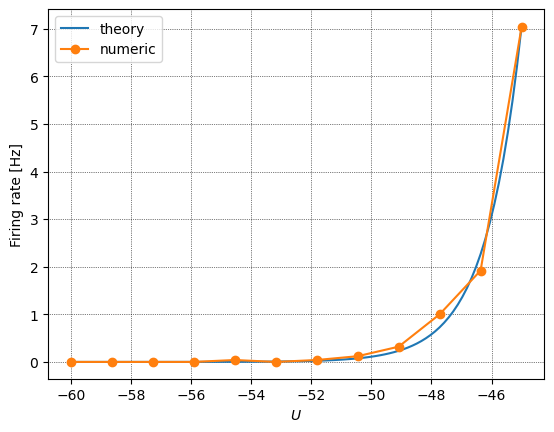

In [19]:
fig, ax = plt.subplots()
ax.plot(U_range_theory, Phi_of_U_theory, label="theory")
ax.plot(U_range_numeric, spike_rate_numeric, marker="o", label="numeric")
ax.legend()
ax.set_xlabel("$U$")
ax.set_ylabel("Firing rate [Hz]")

## Computing reliability of the single neuron model

In [20]:
def evaluate_neuron(neuron_name, nneurons=1, neuron_parms=None, stimulus_type="constant", poisson_fr=0.0,
                    mu=500., sigma=0., t_sim=300., plot=False, rseed=1000, dt=0.1, input_freq=0.0):
    """
    Run a simulation in NEST for the specified neuron. Inject a stepwise
    current and plot the membrane potential dynamics and spikes generated.
    """
    nest.ResetKernel()
    nest.SetKernelStatus({'rng_seed': rseed,
                          'resolution': dt})
    neuron = nest.Create(neuron_name, nneurons)
    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)
    nest.SetStatus(neuron,{'V_m':np.random.uniform(-65.0, -50.0)})
    nest.SetStatus(neuron, "I_e", mu)
    # nest.SetStatus(neuron, {"reset_after_spike": False})

    if stimulus_type == "noise":
        # Create a noise generator
        noise = nest.Create("noise_generator")
        # Set the parameters of the noise generator
        noise_params = {"mean": mu, 
                        "std": sigma, 
                        "dt": dt,
                        "frequency":input_freq}
        nest.SetStatus(noise, noise_params)
        nest.Connect(noise, neuron)

    elif stimulus_type == "poisson_spikes":
        # Create a Poisson generator device
        poisson = nest.Create("poisson_generator", params={"rate": poisson_fr})

        # Create a parrot neuron
        parrot = nest.Create("parrot_neuron")

        # Connect the Poisson generator to the parrot neuron
        nest.Connect(poisson, parrot)

        # Connect the parrot neuron to each neuron
        nest.Connect(parrot, neuron)
    else:
        raise Exception("Unknown stimulus type: " + str(stimulus_type))

    multimeter = nest.Create("multimeter")
    multimeter.set({"record_from": ["V_m"],
                    "interval": dt})
    spike_recorder = nest.Create("spike_recorder")
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)

    nest.Simulate(t_sim)

    dmm = nest.GetStatus(multimeter)[0]
    Voltages = dmm["events"]["V_m"]
    tv = dmm["events"]["times"]
                        
    dSD = nest.GetStatus(spike_recorder, keys='events')[0]
    ns = dSD['senders']
    ts = dSD["times"]

    _idx = [np.argmin((tv - spike_time)**2) - 1 for spike_time in ts]
    V_m_at_spike_times = Voltages[_idx]

    if plot:
        fig, ax = plt.subplots()
        ax.plot(tv, Voltages)
        ax.scatter(ts, V_m_at_spike_times)
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("V_m [mV]")
        ax.grid()

    return ts, ns

### Constant input current


Feb 26 11:18:29 gl_exp5da07fc067fa4f639f92889196944663_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 11:18:29 gl_ca5bc3b424b39f483c8fc6aa7320ab1d07_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 11:18:29 gl_ca5bc3b424b39f483c8fc6aa7320ab1d07_nestml__with_syn_gl_ca5bc3b424b39f483c8fc6aa7320ab1d07_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 11:18:29 gl_expe8800e269e8c4716bc83b2ace5aa5263_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 11:18:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Feb 26 11:18:29 NodeManager::prepare_nodes [Info]: 
    Preparing 54 nodes for simulation.

Feb 26 11:18:29 SimulationMana

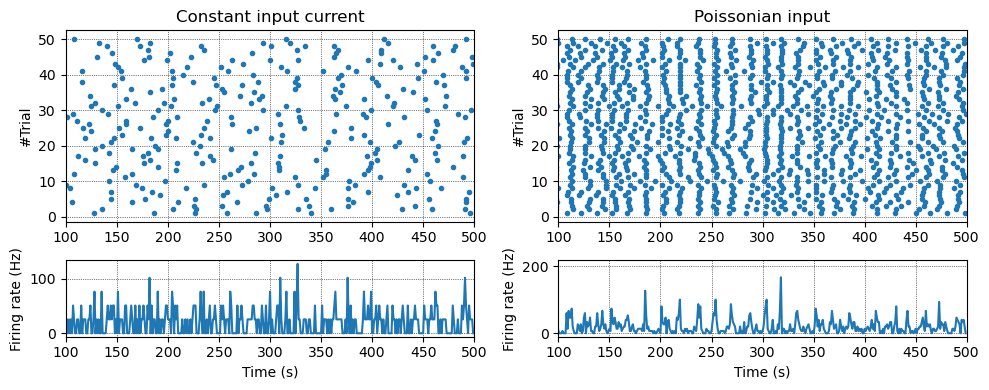

In [26]:
dt = 0.1
nneurons = 50

ts_const, ns_const = evaluate_neuron(neuron_model_name, nneurons=nneurons, neuron_parms=params, stimulus_type='poisson_spikes',\
                          mu=550., t_sim=500.0, dt=dt, poisson_fr = 0.0)

ts_noise, ns_noise = evaluate_neuron(neuron_model_name, nneurons=nneurons, neuron_parms=params, stimulus_type='poisson_spikes',\
                          mu=550., t_sim=500.0, dt=dt, poisson_fr = 1000.0)

# PSTH parameters
t_start = 0.0
t_stop  = 500.0
t_step  = 1.0
t_bins = np.arange(t_start, t_stop + t_step, t_step)

# Calculate the PSTH
psth_const, _ = np.histogram(ts_const, bins=t_bins)
psth_const = psth_const / len(ts_const) / (dt*1e-3)  # divide by number of trials and time bin size

psth_noise, _ = np.histogram(ts_noise, bins=t_bins)
psth_noise = psth_noise / len(ts_noise) / (dt*1e-3)  # divide by number of trials and time bin size

plt.figure(figsize=(10,4))
# Raster plot
plt.subplot2grid((3,2),(0,0), rowspan=2)
plt.plot(ts_const, ns_const, '.')
plt.xlim(100, 500)
plt.ylabel('#Trial')
plt.title('Constant input current')

plt.subplot2grid((3,2),(0,1), rowspan=2)
plt.plot(ts_noise, ns_noise, '.')
plt.xlim(100, 500)
plt.ylabel('#Trial')
plt.title('Poissonian input')

# Plot the PSTH
plt.subplot2grid((3,2),(2,0), rowspan=1)
plt.plot(t_bins[:-1], psth_const)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.xlim(100, 500)

plt.subplot2grid((3,2),(2,1), rowspan=1)
plt.plot(t_bins[:-1], psth_noise)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.xlim(100, 500)
plt.tight_layout()

Normalized model with calcium dynamics
---------------------------------------------------

The `R` variable represents the calcium concentration of the presynaptic neuron. For convenience (and at the cost of some redundancy), we store it here in the NEST synapse object.

In [30]:
nestml_gl_ca_synapse_model = '''
synapse syn_gl_ca:
  state:
    R_pre real = 0.

  parameters:
    the_delay ms = 1 ms  @nest::delay   # !!! cannot have a variable called "delay"
    lmbda real = 2.1555489309487914   # residual calcium decay rate

  onReceive(incoming_spikes):
    R_pre += 1
    deliver_spike(R_pre - 1, the_delay)

  input:
    incoming_spikes <- spike
  
  output:
    spike
  
  update:
    R_pre *= exp(-lmbda * 1E-3 * resolution())   # leakage
'''

Neuron:

In [31]:
nestml_gl_ca_neuron_model = '''
neuron gl_ca:
  state:
    U real = 0     # membrane potential

  parameters:
    a real = 3.
    alpha_over_N real = 1.0777744654743957   # synaptic strength
    beta real = 50     # membrane potential leak
    reset_after_spike boolean = true

  input:
    incoming_spikes <- spike

  output:
    spike

  function phi(U real) real:
    if U <= 0:
      return 0
    return (4 * a) / (1 + exp(a - U)) - (4 * a) / (1 + exp(a))

  equations:
    kernel K = delta(t)
    
    # R is presynaptic neuron's R and is passed as the spike weight by the synapse
    U' = -U / (1E3 / beta) + alpha_over_N * convolve(K, incoming_spikes) / ms

  update:
    # integrate spike input
    integrate_odes()

    # emit spike?
    if random_uniform(0, 1) <= 1E-3 * resolution() * phi(U):
      emit_spike()
      if reset_after_spike:
          U = 0   # reset membrane potential
'''

In [32]:
module_name, neuron_model_name, synapse_model_name = NESTCodeGeneratorUtils.generate_code_for(
    nestml_neuron_model=nestml_gl_ca_neuron_model,
    nestml_synapse_model=nestml_gl_ca_synapse_model,
    logging_level="INFO"  # try "INFO" for more debug information
)

nest.Install(module_name)

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /Users/pooja/nestml/master/doc/tutorials/gl_model/gl_cac582d906cfdd4f76a2f0e5036501ac82.nestml
[3,GLOBAL, INFO]: /Users/pooja/nestml/master/doc/tutorials/gl_model/syn_gl_cac582d906cfdd4f76a2f0e5036501ac82.nestml
[4,GLOBAL, INFO]: Target platform code will be generated in directory: '/Users/pooja/nestml/master/doc/tutorials/gl_model/target'
[5,GLOBAL, INFO]: Target platform code will be installed in directory: '/var/folders/2j/fb047q1177v9f56f_jktrb4c0000gn/T/nestml_target_xxmy68eo'

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Feb 22 2024 10:55:27

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[6,GLOBAL, INFO]: The NEST Simulator version was automatically detected as: v3.6.0
[7,GLOBAL, INFO]: Given te

INFO:root:Analysing input:
INFO:root:{
    "dynamics": [
        {
            "expression": "U' = (-U) / (1000.0 / beta) + alpha_over_N * 0 / 1.0",
            "initial_values": {
                "U": "0"
            }
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "a": "3.0",
        "alpha_over_N": "1.0777744654743957",
        "beta": "50",
        "reset_after_spike": "true"
    }
}
INFO:root:Processing global options...
INFO:root:Processing input shapes...
INFO:root:
Processing differential-equation form shape U with defining expression = "(-U) / (1000.0 / beta) + alpha_over_N * 0 / 1.0"
INFO:root:	Returning shape: Shape "U" of order 1
INFO:root:Shape U: reconstituting expression -0.001*U*beta
INFO:root:All known variables: [U], all parameters used in ODEs: {beta}
INFO:root:
Processing differential-equation form shape U with defining expression = "(-U) / (1000.0 / beta) + alpha_over_N * 0 / 1.0"
INFO:root:	Returning sh

[61,syn_gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml__with_gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml, INFO, [21:17;21:44]]: Implicit casting from (compatible) type 'ms' to 'real'.
[62,syn_gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml__with_gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml, INFO, [11:13;11:13]]: Implicit casting from (compatible) type 'integer' to 'real'.
[63,GLOBAL, INFO]: Successfully constructed neuron-synapse pair gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml__with_syn_gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml, syn_gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml__with_gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml
[64,GLOBAL, INFO]: Analysing/transforming neuron 'gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml'
[65,gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml, INFO, [2:0;40:0]]: Starts processing of the model 'gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml'
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.

INFO:root:Analysing input:
INFO:root:{
    "dynamics": [
        {
            "expression": "U' = (-U) / (1000.0 / beta) + alpha_over_N * 0 / 1.0",
            "initial_values": {
                "U": "0"
            }
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "a": "3.0",
        "alpha_over_N": "1.0777744654743957",
        "beta": "50",
        "reset_after_spike": "true"
    }
}
INFO:root:Processing global options...
INFO:root:Processing input shapes...
INFO:root:
Processing differential-equation form shape U with defining expression = "(-U) / (1000.0 / beta) + alpha_over_N * 0 / 1.0"
INFO:root:	Returning shape: Shape "U" of order 1
INFO:root:Shape U: reconstituting expression -0.001*U*beta
INFO:root:All known variables: [U], all parameters used in ODEs: {beta}
INFO:root:
Processing differential-equation form shape U with defining expression = "(-U) / (1000.0 / beta) + alpha_over_N * 0 / 1.0"
INFO:root:	Returning sh

[67,gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml, INFO, <ADDED_BY_SOLVER>]: Implicit casting from (compatible) type 'ms' to 'real'.
[68,gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml, WARNING, [7:4;7:13]]: Variable 'a' has the same name as a physical unit!
[69,gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml, INFO, [20:13;20:13]]: Implicit casting from (compatible) type 'integer' to 'real'.
[70,gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml, INFO, [9:16;9:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[71,gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml, INFO, [40:14;40:14]]: Implicit casting from (compatible) type 'integer' to 'real'.
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
[72,GLOBAL, INFO]: Analysing/transforming neuron 'gl_cac582d906cfdd4f76a2f0e5036

INFO:root:In ode-toolbox: returning outdict = 
INFO:root:[
    {
        "initial_values": {
            "U": "0"
        },
        "parameters": {
            "beta": "50.0000000000000"
        },
        "propagators": {
            "__P__U__U": "1.0*exp(-0.001*__h*beta)"
        },
        "solver": "analytical",
        "state_variables": [
            "U"
        ],
        "update_expressions": {
            "U": "U*__P__U__U"
        }
    }
]


ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
[75,gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml__with_syn_gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml, INFO, <ADDED_BY_SOLVER>]: Implicit casting from (compatible) type 'ms' to 'real'.
[76,gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml__with_syn_gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml, WARNING, [7:4;7:13]]: Variable 'a' has the same name as a physical unit!
[77,gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml__with_syn_gl_cac582d906cfdd4f76a2f0e5036501ac82_ne

### Postsynaptic response

Note that due to the residual calcium dynamics, the synapse is facilitating.

The decay should correspond to the $\beta$ parameter.

When a neuron spikes, it increases the potential of each postsynaptic partner by $\alpha R/N$.

In [33]:
def measure_postsynaptic_response(neuron_model: str,
                                  synapse_model: str,
                                  t_stop: float = 2250.,
                                  V_m_specifier: str = "V_m",
                                  custom_model_opts: Optional[Dict] = None):
    spike_times = np.array([100., 200., 250., 2000.])

    nest.ResetKernel()
    neuron = nest.Create(neuron_model, params=custom_model_opts)
    neuron.alpha_over_N = 1E-6   # a very low value, to prevent the neuron from spiking
    #dc = nest.Create("dc_generator", params={"amplitude": 1E12 * I_stim})  # 1E12: convert A to pA
    #nest.Connect(dc, neuron)
    spike_generator = nest.Create("spike_generator", params={"spike_times": spike_times})
    nest.Connect(spike_generator, neuron, syn_spec={'synapse_model': synapse_model})

    multimeter = nest.Create('multimeter')
    nest.SetStatus(multimeter, {"record_from": [V_m_specifier]})
    nest.Connect(multimeter, neuron)

    sr = nest.Create('spike_recorder')
    nest.Connect(neuron, sr)

    nest.Simulate(t_stop)

    ts = multimeter.events["times"]
    Vms = multimeter.events[V_m_specifier]
    
    return ts, Vms


Feb 26 11:22:08 NodeManager::prepare_nodes [Info]: 
    Preparing 4 nodes for simulation.

Feb 26 11:22:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4
    Simulation time (ms): 2250
    Number of OpenMP threads: 1
    Not using MPI

Feb 26 11:22:08 SimulationManager::run [Info]: 
    Simulation finished.


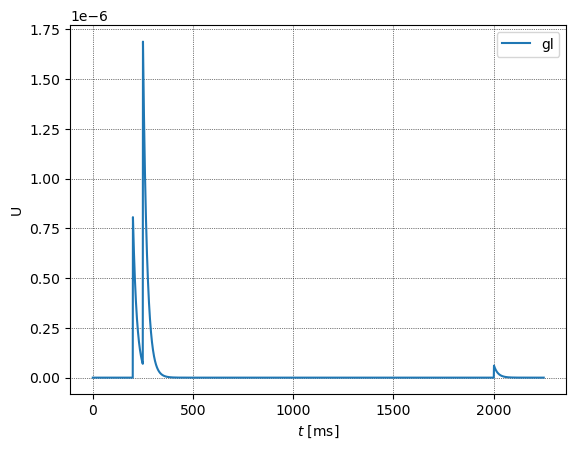

In [34]:
ts, Vms_gl = measure_postsynaptic_response(neuron_model_name, synapse_model_name, V_m_specifier="U")

fig, ax = plt.subplots()
ax.set_xlabel("$t$ [ms]")
ax.plot(ts, Vms_gl, label="gl")
ax.set_ylabel("U")
ax.legend()

### Firing rate

This should correspond to the Phi(U) function in the neuron (see plot below for the theoretical curve).

In [35]:
#theoretical Phi vs U
a = 3
U_range_theory = np.linspace(0., 10., 100)
Phi_of_U_theory = (4 * a) / (1 + np.exp(a - U_range_theory)) - (4 * a) / (1 + np.exp(a))

# numerical Phi vs U
U_range_numeric, spike_rate_numeric = measure_numerical_Phi_function(neuron_model_name=neuron_model_name,
                                                                     neuron_model_params={"reset_after_spike": False,
                                                                                          "beta": 1E-99,   # a very low value, to prevent the membrane potential from decaying
                                                                                          "a": 3.})


Feb 26 11:22:14 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Feb 26 11:22:14 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Feb 26 11:22:14 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Feb 26 11:22:14 gl_exp5da07fc067fa4f639f92889196944663_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 11:22:14 gl_ca5bc3b424b39f483c8fc6aa7320ab1d07_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 11:22:14 gl_ca5bc3b424b39f483c8fc6aa7320ab1d07_nestml__with_syn_gl_ca5bc3b424b39f483c8fc6aa7320ab1d07_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 11:22:14 gl_expe8800e269e8c4716bc83b2ace5aa5263_nestml [Warning]: 
    Simulation resolution has cha

Text(0, 0.5, 'Firing rate [Hz]')

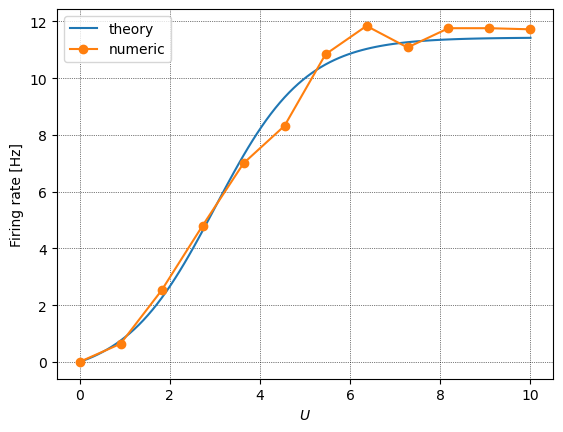

In [36]:
fig, ax = plt.subplots()
ax.plot(U_range_theory, Phi_of_U_theory, label="theory")
ax.plot(U_range_numeric, spike_rate_numeric, marker="o", label="numeric")
ax.legend()
ax.set_xlabel("$U$")
ax.set_ylabel("Firing rate [Hz]")

### Network dynamics

In [55]:
foo=None
def run_simulation_in_chunks(sim_chunks, sim_time, syn_recordables, neurons):
    global foo
    sim_time_per_chunk = sim_time / sim_chunks

    # Init log to collect the values of all recordables
    log = {}
    log["t"] = []

    # Initialize all the arrays
    # Additional one entry is to store the trace value before the simulation begins
    for rec in syn_recordables:
        log[rec] = (sim_chunks + 1) * [[]]

    # Get the value of trace values before the simulation
    syn = nest.GetConnections(target=neurons, synapse_model=synapse_model_name)
    print(str(len(syn)) + " synapses in the network")
    foo=syn
    for rec in syn_recordables:
        log[rec][0] = syn.get(rec)
        
    log["t"].append(nest.GetKernelStatus("biological_time"))

    # Run the simulation in chunks
    for i in range(sim_chunks):
        sim_start_time = i * sim_time_per_chunk
        sim_end_time = sim_start_time + sim_time_per_chunk

        nest.Simulate(np.round(sim_time/sim_chunks))
        
        # log current values
        log["t"].append(nest.GetKernelStatus("biological_time"))

        # Get the value of trace after the simulation
        for rec in syn_recordables:
            log[rec][i + 1] = syn.get(rec).copy()
            
    #nest.Cleanup()
    
    return log


In [56]:
N = 100      # Number of neurons in network XXX: 1000 in the original paper
conn_prob = 1.

a = 2.

beta = 50.
lmbda = 10.
alpha = beta * lmbda

U_0 = 1.#0.79555   # initial membrane potential
R_0 = .2#1.   # initial residual calcium

U_range = .1 * U_0
R_range = .1 * R_0

In [63]:
nest.ResetKernel()
nest.resolution = .1 # [ms]

sim_time = 1000.   # [ms] XXX: 120 second original paper
chunk_length = 10.   # [ms]
n_chunks = int(sim_time / chunk_length)
syn_recordables = ["R_pre"]

pop = nest.Create(neuron_model_name, N)
pop.a = a
pop.alpha_over_N = alpha / N
pop.beta = beta
pop.U = [U_0 + U_range * (random.random() - .5) for _ in range(N)]

conn_spec_dict = {'rule': 'pairwise_bernoulli', 'p': conn_prob, 'allow_autapses': False}
nest.Connect(pop, pop, conn_spec_dict, syn_spec={'synapse_model': synapse_model_name, 'lmbda': lmbda})

#syn_recordables = []
#nest.Connect(pop, pop, conn_spec_dict, syn_spec={'synapse_model': 'static_synapse'})


syn = nest.GetConnections(target=pop, synapse_model=synapse_model_name)
N_syn = len(syn)
syn.R_pre = [R_0 + R_range * (random.random() - .5) for _ in range(N_syn)]

multimeter = nest.Create("multimeter")
multimeter.set({"record_from": ["U"], "interval": nest.resolution})
nest.Connect(multimeter, pop)

sr = nest.Create('spike_recorder')
nest.Connect(pop, sr)

log = run_simulation_in_chunks(n_chunks, sim_time, syn_recordables, pop)


"""nest.Simulate(sim_time)

neuron_ids = np.unique(multimeter.get("events")["senders"])

fig, ax = plt.subplots(nrows=2)

U_avg = np.zeros(len(np.unique( multimeter.get("events")["times"])))
# R_avg = np.zeros_like(U_avg)
for neuron_id in range(1, N+1):
    idx = np.where(neuron_id == multimeter.get("events")["senders"])
    times = multimeter.get("events")["times"][idx]
    U = multimeter.get("events")["U"][idx]
    #R = multimeter.get("events")["R"][idx]
    
    U_avg += U / N
    #R_avg += R / N

    if neuron_id < 100:
        ax[0].plot(U, label="U")
#         ax[1].plot(R, label="R")

ax[0].plot(U_avg, linewidth=4, linestyle="--", c="black")
ax[0].set_ylabel("U")
# ax[1].plot(R_avg, linewidth=4, linestyle="--", c="black")
ax[1].set_ylabel("R")

for _ax in ax:
    _ax.set_xlim(0, sim_time)
ax[-1].set_xlabel("Time [ms]")"""


Feb 26 12:06:13 gl_exp5da07fc067fa4f639f92889196944663_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 12:06:13 gl_ca5bc3b424b39f483c8fc6aa7320ab1d07_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 12:06:13 gl_ca5bc3b424b39f483c8fc6aa7320ab1d07_nestml__with_syn_gl_ca5bc3b424b39f483c8fc6aa7320ab1d07_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 12:06:13 gl_expe8800e269e8c4716bc83b2ace5aa5263_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 12:06:13 gl_cac582d906cfdd4f76a2f0e5036501ac82_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 12:06:13 gl_cac582d906cfdd4f76a2f0e5036501ac8

'nest.Simulate(sim_time)\n\nneuron_ids = np.unique(multimeter.get("events")["senders"])\n\nfig, ax = plt.subplots(nrows=2)\n\nU_avg = np.zeros(len(np.unique( multimeter.get("events")["times"])))\n# R_avg = np.zeros_like(U_avg)\nfor neuron_id in range(1, N+1):\n    idx = np.where(neuron_id == multimeter.get("events")["senders"])\n    times = multimeter.get("events")["times"][idx]\n    U = multimeter.get("events")["U"][idx]\n    #R = multimeter.get("events")["R"][idx]\n    \n    U_avg += U / N\n    #R_avg += R / N\n\n    if neuron_id < 100:\n        ax[0].plot(U, label="U")\n#         ax[1].plot(R, label="R")\n\nax[0].plot(U_avg, linewidth=4, linestyle="--", c="black")\nax[0].set_ylabel("U")\n# ax[1].plot(R_avg, linewidth=4, linestyle="--", c="black")\nax[1].set_ylabel("R")\n\nfor _ax in ax:\n    _ax.set_xlim(0, sim_time)\nax[-1].set_xlabel("Time [ms]")'

Text(0.5, 0.98, 'R')

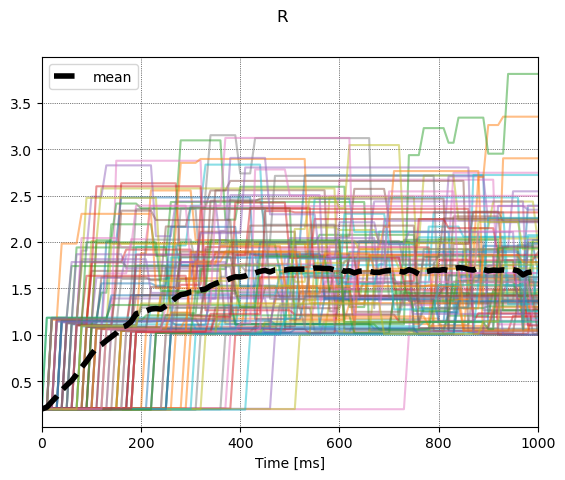

In [64]:
times = log["t"]
R_pre = np.array(log["R_pre"])
R_pre_avg = np.mean(R_pre, axis=1)


fig, ax = plt.subplots()
ax.plot(times, R_pre[:, ::N], alpha=.5)   # XXX: plot only every N-th line
ax.set_xlim(0, sim_time)
ax.set_xlabel("Time [ms]")
ax.plot(times, R_pre_avg, linewidth=4, linestyle="--", c="black", label="mean")
ax.legend()
fig.suptitle("R")

Text(0, 0.5, 'Neuron')

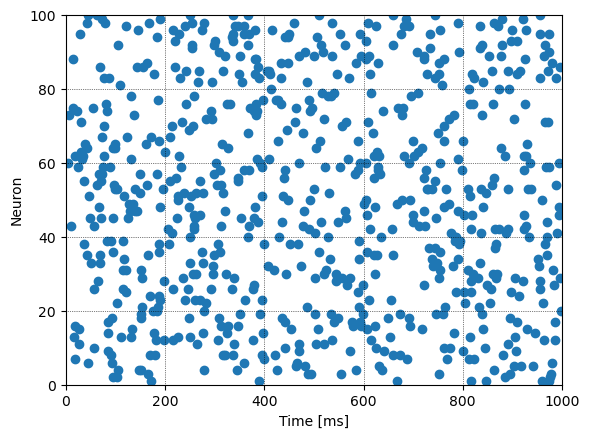

In [65]:
fig, ax = plt.subplots()
ax.scatter(sr.events["times"], sr.events["senders"])
ax.set_ylim(0, N)
ax.set_xlim(0, sim_time)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Neuron")

In [66]:
avg_firing_rate = len(sr.events["times"]) / N / (sim_time / 1E3)
print("Network average firing rate: " + str(avg_firing_rate) + " Hz")

Network average firing rate: 7.1 Hz


Text(0.5, 0.98, 'U')

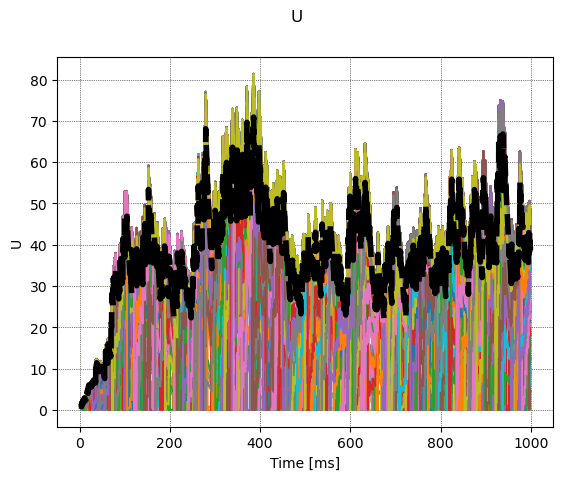

In [67]:
neuron_ids = np.unique(multimeter.get("events")["senders"])

fig, ax = plt.subplots()

U_avg = np.zeros(len(np.unique(multimeter.get("events")["times"])))
for neuron_id in range(1, N+1):
    idx = np.where(neuron_id == multimeter.get("events")["senders"])
    times = multimeter.get("events")["times"][idx]
    U = multimeter.get("events")["U"][idx]
    
    U_avg += U / N

    if neuron_id < 100:
        ax.plot(times, U, label="U")

ax.plot(times, U_avg, linewidth=4, linestyle="--", c="black")
ax.set_ylabel("U")
ax.set_xlabel("Time [ms]")
fig.suptitle("U")

### Comparison to theory

(0.01, 6)

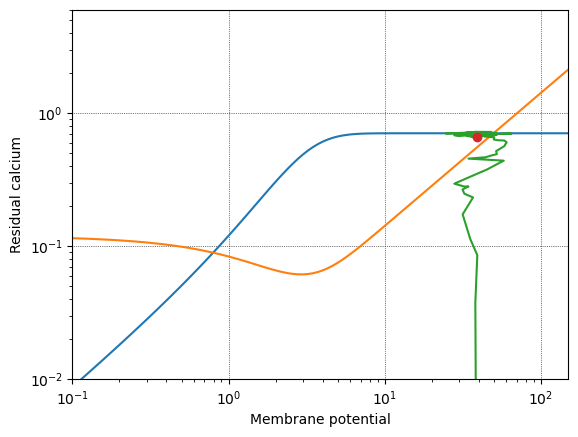

In [68]:
def phi(x):
    return (4 * a) / (1 + np.exp(a - x)) - (4 * a) / (1 + np.exp(a))

def nullcline1(x):
    return phi(x)/lmbda

def nullcline2(x):
    return beta/alpha*x/phi(x)

U_vec = np.logspace(np.log10(.1), np.log10(150), 100)

nullcline1_vec = nullcline1(U_vec)
nullcline2_vec = nullcline2(U_vec)

fig, ax = plt.subplots()
ax.loglog(U_vec, nullcline1_vec)
ax.loglog(U_vec, nullcline2_vec)

U_avg_intrp = np.interp(np.linspace(0, len(U_avg), 100),
                        np.arange(len(U_avg)),
                        U_avg)

R_pre_intrp = np.interp(np.linspace(0, len(R_pre_avg), 100),
                        np.arange(len(R_pre_avg)),
                        R_pre_avg)

R_pre_intrp[ R_pre_intrp <= 1] = 1.000001

#ax.loglog(U_avg[::200], R_pre_avg[:50] - 1)
ax.loglog(U_avg_intrp, R_pre_intrp - 1)
ax.loglog(U_avg[-1], R_pre_avg[-1] - 1, marker="o")

#ax.scatter(U_avg[:199], R_pre_avg[:199])

ax.set_xlabel('Membrane potential')
ax.set_ylabel('Residual calcium')
ax.set_xlim(np.amin(U_vec), np.amax(U_vec))
ax.set_ylim(.01, 6)

#ax.plot(U_avg, R_avg)

## Acknowledgements

...


## References

...


## Copyright

This file is part of NEST.

Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with NEST.  If not, see <http://www.gnu.org/licenses/>.
